In [229]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif, chi2, SelectKBest
set_config(display='diagram')

## **Read data from UCI dataset**

In [230]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv', sep=',')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [231]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

After reviewing, we have made decision on the feature of `Revenue` as our targets to research in this campain.

In [232]:
df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [233]:
y = df['Revenue']
X = df.drop('Revenue', axis=1)

Below, we would refer to split the data set into train set and test set with ratio of (70%, 30%) of data set. Moreover, from the train set, we continue spliting a part of it for validation set with ratio of (80%, 20%) of train set.

In [234]:
X_df, test_X_df, y_sr, test_y_sr = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.25, stratify=y_sr, random_state=0)

In [235]:
print(f"Train X set shape: {train_X_df.shape}")
print(f"Train y set shape: {train_y_sr.shape}")
print(f"Validate X set shape: {val_X_df.shape}")
print(f"Validate y set shape: {val_y_sr.shape}")
print(f"Test X set shape: {test_X_df.shape}")
print(f"Test y set shape: {test_y_sr.shape}")

Train X set shape: (6473, 17)
Train y set shape: (6473,)
Validate X set shape: (2158, 17)
Validate y set shape: (2158,)
Test X set shape: (3699, 17)
Test y set shape: (3699,)


We just `randome_state` the `train_test_split` to make the training process more efficient in general.

In [236]:
train_X_df.head().index

Int64Index([7126, 3617, 4491, 3824, 10164], dtype='int64')

In [237]:
train_X_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
7126,2,30.20,0,0.0,29,630.326667,0.006667,0.023333,0.000000,0.0,Sep,2,2,6,1,Returning_Visitor,False
3617,0,0.00,0,0.0,11,855.250000,0.018182,0.063636,0.000000,0.0,May,2,2,3,13,Returning_Visitor,False
4491,3,48.00,0,0.0,10,129.500000,0.000000,0.018182,0.000000,0.0,May,2,5,9,4,Returning_Visitor,False
3824,0,0.00,0,0.0,8,202.833333,0.000000,0.014286,0.000000,0.0,May,2,4,1,2,Returning_Visitor,False
10164,3,52.75,0,0.0,31,3069.077778,0.006452,0.020538,5.793027,0.0,Nov,1,1,3,2,Returning_Visitor,False


In [238]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_list=[], num_top_values_list=[], default=-1):
        self.num_top_values_list = num_top_values_list
        self.columns_list = columns_list
        self.default = default

    def getLogicNumberTopValue(self, X_df, column):
        counts = X_df[column].value_counts()
        return sum([1 for value in list(counts.values) if value>(1*max(list(counts.values))/100)])

    def reprocessing_data(self, X_df):
        self.columns_list = [column for column in self.columns_list if len(X_df[column].value_counts())>=5]
        if len(self.num_top_values_list)==0:
            self.num_top_values_list = [self.getLogicNumberTopValue(X_df, column) for column in self.columns_list]

    def fit(self, X_df, y=None):
        self.reprocessing_data(X_df)
        self.top_values_list = []

        for column, num_top_values in zip(self.columns_list, self.num_top_values_list):
            self.counts_ = X_df[column].value_counts()
            ids = list(self.counts_.index)
            self.top_values_list.append(ids[:max(1, min(num_top_values, len(ids)))])
        return self
    
    def transform(self, X_df, y=None):
        out_df = X_df.copy()
        for top_value, column in zip(self.top_values_list, self.columns_list):
            out_df.loc[~out_df[column].isin(top_value), column] = self.default
            out_df = out_df.sort_index(axis=1)
        return out_df

In [239]:
cate_cols = df.select_dtypes('object').columns
nume_cols = X.columns.drop(cate_cols)

In [240]:
col_adderdropper = ColAdderDropper(columns_list=cate_cols)
col_adderdropper.fit(train_X_df)
new_train_X_df = col_adderdropper.transform(train_X_df)
new_train_X_df.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
7126,2,30.20,0.006667,2,0.023333,0,0.0,Sep,2,0.000000,29,630.326667,6,0.0,1,Returning_Visitor,False
3617,0,0.00,0.018182,2,0.063636,0,0.0,May,2,0.000000,11,855.250000,3,0.0,13,Returning_Visitor,False
4491,3,48.00,0.000000,5,0.018182,0,0.0,May,2,0.000000,10,129.500000,9,0.0,4,Returning_Visitor,False
3824,0,0.00,0.000000,4,0.014286,0,0.0,May,2,0.000000,8,202.833333,1,0.0,2,Returning_Visitor,False
10164,3,52.75,0.006452,1,0.020538,0,0.0,Nov,1,5.793027,31,3069.077778,3,0.0,2,Returning_Visitor,False


In [260]:
numerics_trans = SimpleImputer()
categorical_trans=make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_trans = make_column_transformer(
    (numerics_trans, nume_cols),
    (categorical_trans, cate_cols)
)

preprocess_pipeline = make_pipeline(col_adderdropper, column_trans, StandardScaler(with_mean=False))
preprocess_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocess_pipeline

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(columns_list=['Month'],
                                 num_top_values_list=[10])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend'],
      dtype='object')),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Month', 'VisitorType'], dtype='object'))])),
                ('standardscaler', StandardScaler(with_mean=False))])

In [261]:
class OneHotEncoding:
    def __init__(self, columns, handle_unknown_type='ignore', isSparse=False):
        self.model = OneHotEncoder(handle_unknown=handle_unknown_type, sparse=isSparse)
        self.columns = columns
        
    def fit_transform(self, df, visualize=False):
        for col in self.columns:
            self.matrix = self.model.fit_transform(df[[col]])  # get a matrix of new features and values
            names = self.model.get_feature_names_out()  # get names for these features
            df_oh = pd.DataFrame(data=self.matrix, columns=names, index=df.index)
            if visualize: display(df_oh.plot.hist())
            df = pd.concat([df, df_oh], axis=1)
            df.drop(col, axis=1, inplace=True)
        return df

    def retransform_with_values(self, columns, values):
        dic = {}
        for col, value in zip(columns, values):
            split_col = col.rsplit('_')
            if split_col[0] not in dic:
                dic[split_col[0]] = (value, 1)
            else:
                dic[split_col[0]] = (dic[split_col[0]][0]+value, dic[split_col[0]][1]+1)
        key = list(dic.keys())
        return key, [dic[k][0]/dic[k][1] for k in key]


One-hot-encoding for all the object features in the categorical features

In [262]:
cate_df = train_X_df.drop(nume_cols, axis=1)
onehotencoder = OneHotEncoding(cate_df.select_dtypes("object").columns, handle_unknown_type='ignore', isSparse=False)
cate_ohc_df = onehotencoder.fit_transform(cate_df)
cate_ohc_df

,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
7126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3617,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3824,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1552,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8109,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1149,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Array of F-Statistic that present for the affect estimation between each numerical features with the target

In [263]:
f_statistics, p_values = f_regression(train_X_df.drop(cate_cols, axis=1), train_y_sr)
for col, value in zip(nume_cols, f_statistics):
    print(f'{col}: {value.round(5)}')

Administrative: 126.70113
Administrative_Duration: 65.40697
Informational: 52.77793
Informational_Duration: 19.79106
ProductRelated: 154.69062
ProductRelated_Duration: 150.00512
BounceRates: 151.63142
ExitRates: 289.70428
PageValues: 2113.78432
SpecialDay: 38.51842
OperatingSystems: 0.79887
Browser: 4.0649
Region: 0.4993
TrafficType: 1.29413
Weekend: 7.91323


Array of estimate mutual information of categorical features for a target variable

$$Estimate = \sum \limits_{i=1}^{n} \frac{(\chi_{i}-mean(\chi))*(\gamma-mean(\gamma))}{std(\chi_{i})*std(\gamma)}$$

In [264]:
estimate = mutual_info_classif(cate_ohc_df, train_y_sr, discrete_features='auto', copy=True, random_state=1)
cate_colums, new_estimate = onehotencoder.retransform_with_values(cate_ohc_df.columns, estimate)
for col, value in zip(cate_colums, new_estimate):
    print(f'{col}: {value.round(5)}')

Month: 0.00284
VisitorType: 0.00343


In [290]:
train_accs = []
val_accs = []
alphas = [0,0.01,0.1, 1, 10, 100]
k_s = [3, 5, 7, 9, 15, 17]
best_val_acc = 0
best_alpha = None
best_k = None

full_pipeline = make_pipeline(
    preprocess_pipeline,
    SelectKBest(chi2),
    MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=0, learning_rate_init=0.05, max_iter=100)
)
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(columns_list=['Month'],
                                                  num_top_values_list=[10])),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       '...
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   Index(['Month', 'VisitorType'], dtype='object'))])),
                                 ('standardscaler',
                                  StandardScaler(with_mean=False))])),
                ('selectkbest',
                 SelectKBest(score_func=<function chi2 at 0x00000261D99065F0>)),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=50, learning_rate_init=0.05,
                               max_iter=100, random_state=0))])

In [286]:
# full_pipeline.set_params(selectkbest__k=15)
# full_pipeline.fit(train_X_df, train_y_sr)
# train_score, val_score = full_pipeline.score(train_X_df, train_y_sr)*100, full_pipeline.score(val_X_df, val_y_sr)*100
for alpha in alphas:
    for k in k_s:
        full_pipeline.set_params(selectkbest__k=k, mlpclassifier__alpha=alpha)
        full_pipeline.fit(train_X_df, train_y_sr)
        train_score, val_score = full_pipeline.score(train_X_df, train_y_sr)*100, full_pipeline.score(val_X_df, val_y_sr)*100
        train_accs.append(train_score)
        val_accs.append(val_score)
        if val_score>best_val_acc:
            best_val_acc, best_alpha, best_k = val_score, alpha, k

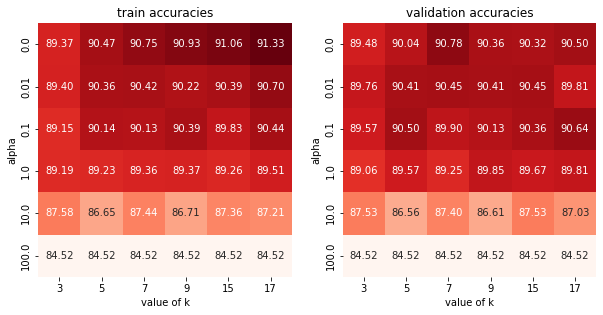

In [288]:
# Visualizing the result
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(alphas), -1),
                             index=alphas, columns=k_s)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(alphas), -1), 
    index=alphas, columns=k_s)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies'); plt.xlabel('value of k'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies'); plt.xlabel('value of k'); plt.ylabel('alpha');